C:\Users\bok\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
28/28 - 4s - loss: 0.1367 - val_loss: 0.0784
Epoch 2/50
28/28 - 0s - loss: 0.1672 - val_loss: 0.0059
Epoch 3/50
28/28 - 0s - loss: 0.0349 - val_loss: 0.0858
Epoch 4/50
28/28 - 0s - loss: 0.0822 - val_loss: 0.0628
Epoch 5/50
28/28 - 0s - loss: 0.0087 - val_loss: 0.0093
Epoch 6/50
28/28 - 0s - loss: 0.0071 - val_loss: 0.0128
Epoch 7/50
28/28 - 0s - loss: 0.0019 - val_loss: 0.0151
Epoch 8/50
28/28 - 0s - loss: 0.0021 - val_loss: 0.0085
Epoch 9/50
28/28 - 0s - loss: 0.0023 - val_loss: 0.0074
Epoch 10/50
28/28 - 0s - loss: 0.0014 - val_loss: 0.0081
Epoch 11/50
28/28 - 0s - loss: 0.0012 - val_loss: 0.0072
Epoch 12/50
28/28 - 0s - loss: 0.0020 - val_loss: 0.0063
Epoch 13/50
28/28 - 0s - loss: 0.0027 - val_loss: 0.0065
Epoch 14/50
28/28 - 0s - loss: 0.0019 - val_loss: 0.0062
Epoch 15/50
28/28 - 0s - loss: 0.0013 - val_loss: 0.0047
Epoch 16/50
28/28 - 0s - loss: 0.0034 - val_loss: 0.0035
Epoch 17/50
28/28 - 0s - loss: 0.0086 - val_loss: 0.0051
Epoch 18/50
28/28 - 0s - loss: 0.0122 - 

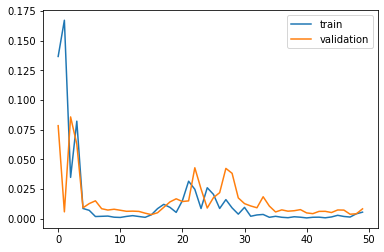

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               168960    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 185,473
Trainable params: 185,473
Non-trainable params: 0
_________________________________________________________________
None
0.0915157983282259


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow

from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot
from pickle import load

X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

#Parameters
LR = 0.001
BATCH_SIZE = 64
N_EPOCH = 50

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model

model = basic_lstm(input_dim, feature_size)
model.save('LSTM_3to1.h5')
print(model.summary())

yhat = model.predict(X_test, verbose=0)
#print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

# %% --------------------------------------- Plot the TRAIN result  -----------------------------------------------------------------
## TRAIN DATA
def plot_traindataset_result(X_train, y_train):


    train_yhat = model.predict(X_train, verbose=0)

    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
    #
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Train RMSE -- ', RMSE)

    return RMSE






# %% --------------------------------------- Plot the TEST result  -----------------------------------------------------------------
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2020-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE -- ', RMSE)

    return RMSE

def plot_testdataset_with2020_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2020", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE with 2020 -- ', RMSE)

    return RMSE

train_RMSE = plot_traindataset_result(X_train, y_train)
print("----- Train_RMSE_LSTM -----", train_RMSE)

test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_LSTM -----", test_RMSE)

test_with2020_RMSE = plot_testdataset_with2020_result(X_test, y_test)
print("----- Test_RMSE_LSTM_with2020 -----", test_with2020_RMSE)




'''def plot_last3_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test[-1].reshape(1, X_test[-1].shape[0], X_test[-1].shape[1]), verbose=0)

    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test[-32:])
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    #print("----- test dataset rescaled predicted price -----", rescaled_predicted_y)
    #print("----- test dataset SHAPE rescaled predicted price -----", rescaled_predicted_y.shape)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        test_predict_index = test_predict_index[-34:]
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    ## Predicted price
    predict_result = pd.DataFrame()
    y_predict = pd.DataFrame(rescaled_predicted_y[0], columns=["predicted_price"], index=test_predict_index[-3:])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    #plt.ylim(0, 110)
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of the last set of testdata", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real[-3:]))
    #print('-- test dataset RMSE -- ', RMSE)

    return RMSE'''




